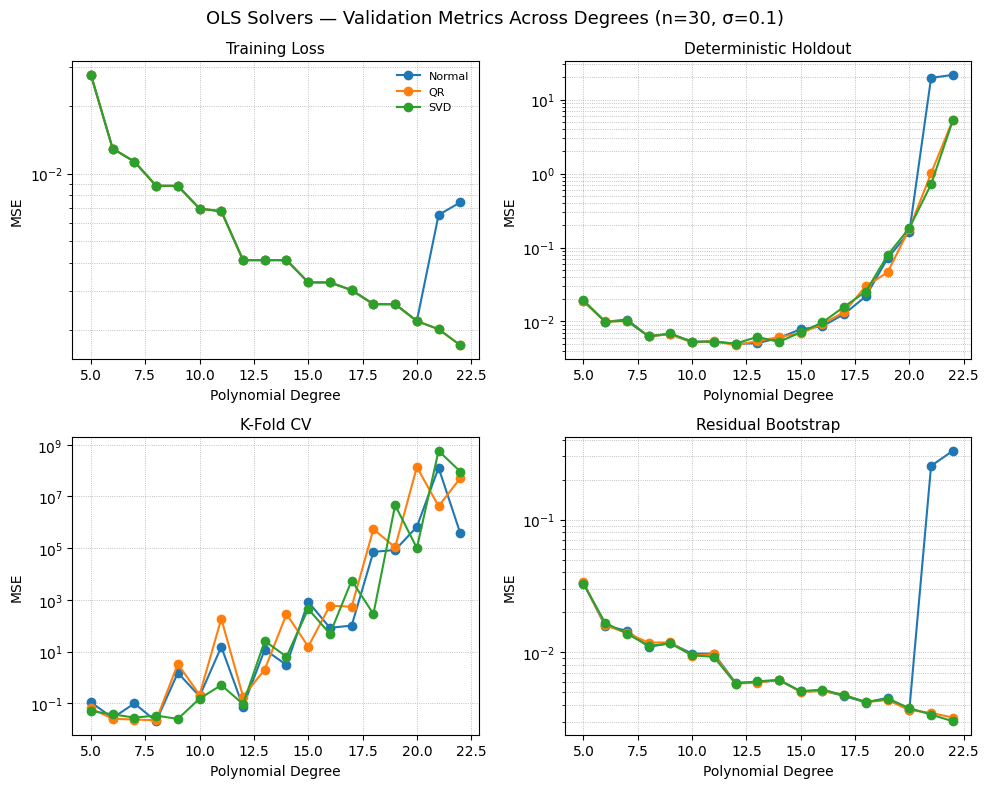

Saved 2×2 validation plot to:
c:\Users\vikto\Desktop\fysstk3155\project-1\code\figures\ols_validation_metrics_2x2.pdf


In [ ]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(314)
from src.data import equispaced_points, runge_function
from src.basis import vandermonde
from src.regression import ols_normal, ols_qr, ols_svd
from src.validation import deterministic_holdout, kfold_cv, residual_bootstrap

# -------------------
# Config
# -------------------
degrees = np.arange(5, 23)
x = equispaced_points(30)
y_true = runge_function(x)
y = runge_function(x) + np.random.normal(0, 0.1, size=len(x))

solvers = {"Normal": ols_normal, "QR": ols_qr, "SVD": ols_svd}
methods = ["Training Loss", "Deterministic Holdout", "K-Fold CV", "Residual Bootstrap"]

results = {method: {solver: [] for solver in solvers} for method in methods}

# -------------------
# Compute metrics
# -------------------

for d in degrees:
    X = vandermonde(x, d)
    for name, solver in solvers.items():
        coef, predict_fn, info = solver(X, y)
        y_pred_train = predict_fn(X, coef)
        train_loss = np.mean((y - y_pred_train) ** 2)

        results["Training Loss"][name].append(train_loss)
        results["Deterministic Holdout"][name].append(
            deterministic_holdout(x, y_true, runge_function, d, solver, B=40, sigma=0.1)
        )
        results["K-Fold CV"][name].append(
            kfold_cv(x, y, d, solver, K=5)
        )
        results["Residual Bootstrap"][name].append(
            residual_bootstrap(x, y, d, solver, B=40)
        )

# -------------------
# Plot 2×2 Validation Grid
# -------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

colors = {"Normal": "C0", "QR": "C1", "SVD": "C2"}

for i, method in enumerate(methods):
    ax = axes[i]
    for solver_name, color in colors.items():
        ax.plot(degrees, results[method][solver_name], "o-", label=solver_name, color=color)
    ax.set_title(method, fontsize=11)
    ax.set_xlabel("Polynomial Degree")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle=":", linewidth=0.6)
    if i == 0:
        ax.legend(frameon=False, fontsize=8)

fig.suptitle("OLS Solvers — Validation Metrics Across Degrees (n=30, σ=0.1)", fontsize=13, y=0.98)
plt.tight_layout()
plt.show()

# -------------------
# Save results
# -------------------
fig_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
os.makedirs(fig_dir, exist_ok=True)

out_path = os.path.join(fig_dir, 'ols_validation_metrics_2x2.pdf')
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved 2×2 validation plot to:\n{out_path}")


c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.wa

Saved SGD comparison plot to:
c:\Users\vikto\Desktop\fysstk3155\project-1\code\figures\ols_sgd_comparison.pdf


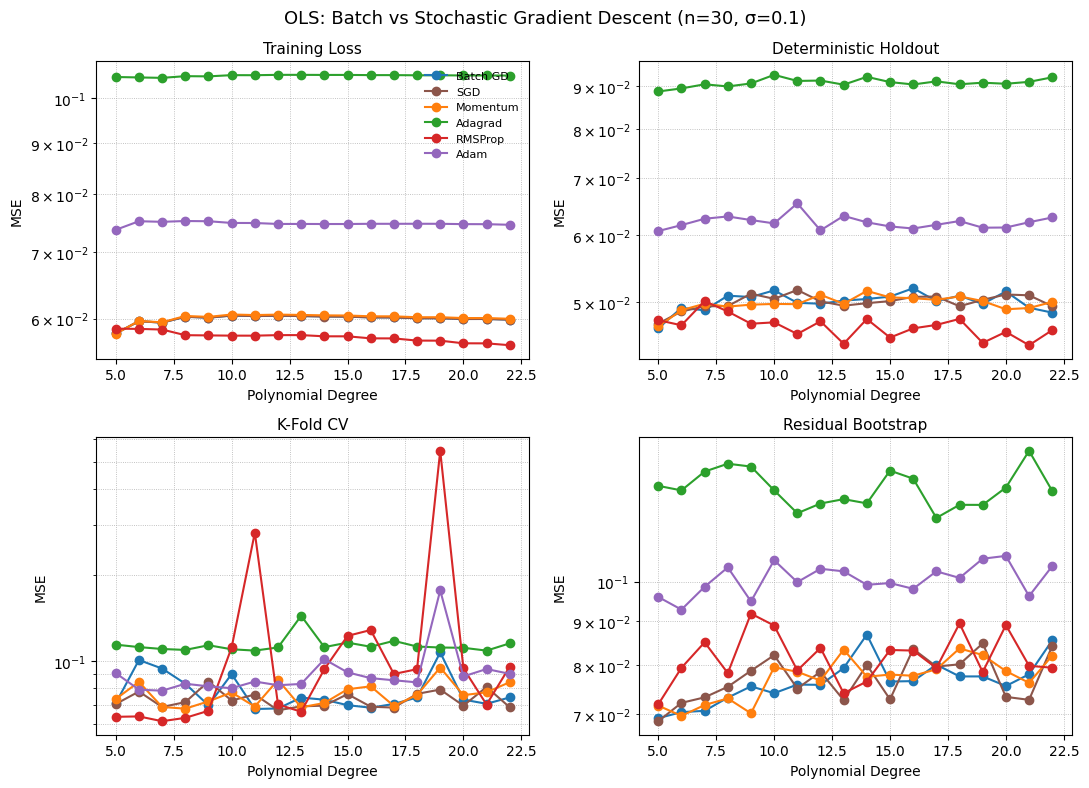

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from src.data import equispaced_points, runge_function
from src.basis import vandermonde
from src.gd import (
    batch_gradient_descent,
    sgd_sklearn,  # Add SGD
    momentum_gradient_descent,
    adagrad_solver,
    rmsprop_solver,
    adam_solver,
)
from src.regression import predict
from src.validation import deterministic_holdout, kfold_cv, residual_bootstrap

np.random.seed(314)

# -------------------
# Config
# -------------------
degrees = np.arange(5, 23)
x = equispaced_points(30)
y = runge_function(x) + np.random.normal(0, 0.1, size=len(x))

solvers = {
    "Batch GD": lambda X, y: batch_gradient_descent(X, y, eta=1e-3, max_iter=400),
    "SGD": lambda X, y: sgd_sklearn(X, y, eta=1e-3, max_iter=400, alpha=0.0),  # OLS with SGD
    "Momentum": lambda X, y: momentum_gradient_descent(X, y, eta=1e-3, beta=0.9, max_iter=400),
    "Adagrad": lambda X, y: adagrad_solver(X, y, lr=5e-3, max_iter=400),
    "RMSProp": lambda X, y: rmsprop_solver(X, y, lr=1e-3, max_iter=400),
    "Adam": lambda X, y: adam_solver(X, y, lr=1e-3, max_iter=400),
}

methods = ["Training Loss", "Deterministic Holdout", "K-Fold CV", "Residual Bootstrap"]
results = {m: {s: [] for s in solvers} for m in methods}

# -------------------
# Lightened sampling
# -------------------
HOLDOUT_B = 5
BOOTSTRAP_B = 5
K_FOLDS = 3

# -------------------
# Compute metrics
# -------------------
for d in degrees:
    X = vandermonde(x, d)
    for name, solver in solvers.items():
        coef, predict_fn, info = solver(X, y)
        y_pred_train = predict_fn(X, coef)
        train_loss = np.mean((y - y_pred_train) ** 2)
        
        results["Training Loss"][name].append(train_loss)
        results["Deterministic Holdout"][name].append(
            deterministic_holdout(x, y, runge_function, d, solver, B=HOLDOUT_B, sigma=0.1)
        )
        results["K-Fold CV"][name].append(kfold_cv(x, y, d, solver, K=K_FOLDS))
        results["Residual Bootstrap"][name].append(
            residual_bootstrap(x, y, d, solver, B=BOOTSTRAP_B)
        )

# -------------------
# Plot 2×2 Validation Grid
# -------------------
fig, axes = plt.subplots(2, 2, figsize=(11, 8))
axes = axes.ravel()

colors = {
    "Batch GD": "C0",
    "SGD": "C5",  # Different color for SGD
    "Momentum": "C1",
    "Adagrad": "C2",
    "RMSProp": "C3",
    "Adam": "C4",
}

for i, method in enumerate(methods):
    ax = axes[i]
    for solver_name, color in colors.items():
        ax.plot(degrees, results[method][solver_name], "o-", label=solver_name, color=color)
    ax.set_title(method, fontsize=11)
    ax.set_xlabel("Polynomial Degree")
    ax.set_ylabel("MSE")
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle=":", linewidth=0.6)
    if i == 0:
        ax.legend(frameon=False, fontsize=8)

fig.suptitle(
    "OLS: Batch vs Stochastic Gradient Descent (n=30, σ=0.1)",
    fontsize=13,
    y=0.98,
)
plt.tight_layout()

# -------------------
# Save results
# -------------------
fig_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
os.makedirs(fig_dir, exist_ok=True)

out_path = os.path.join(fig_dir, 'ols_sgd_comparison.pdf')
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved SGD comparison plot to:\n{out_path}")
plt.show()

c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\vikto\Desktop\fysstk3155\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.wa

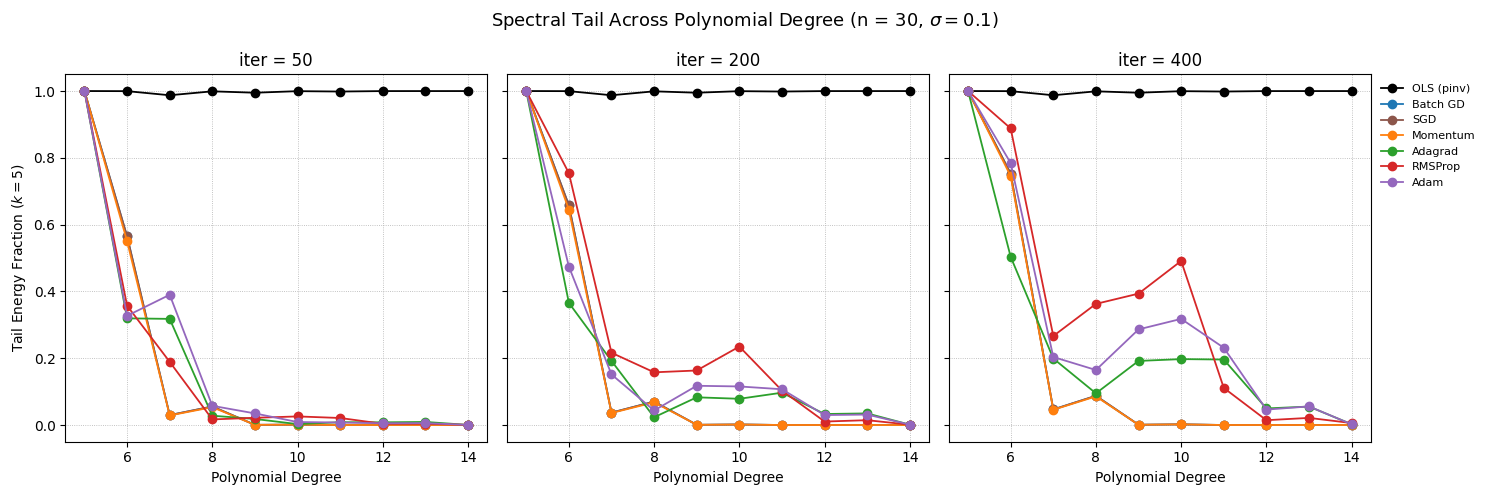

Saved 3×1 spectral tail plot to:
c:\Users\vikto\Desktop\fysstk3155\project-1\code\figures\spectral_tail_across_degree_multi_iter_with_sgd.pdf


In [3]:
# -----------------------------
# Spectral Tail Energy Across Polynomial Degree
# -----------------------------
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from src.data import equispaced_points, runge_function
from src.basis import vandermonde
from src.gd import (
    batch_gradient_descent,
    sgd_sklearn,
    momentum_gradient_descent,
    adagrad_solver,
    rmsprop_solver,
    adam_solver,
)

# -----------------------------
# Config
# -----------------------------
n = 30
sigma = 0.1
degrees = np.arange(5, 15)
x = equispaced_points(n)
y = runge_function(x) + np.random.normal(0, sigma, size=len(x))
k = 5  # tail cutoff
iteration_set = [50, 200, 400]

# -----------------------------
# Solver factory (parameterized by max_iter)
# -----------------------------
def get_solvers(max_iter):
    return {
        "OLS (pinv)": lambda X, y: (np.linalg.pinv(X) @ y, None, None),
        "Batch GD": lambda X, y: batch_gradient_descent(X, y, eta=1e-3, max_iter=max_iter),
        "SGD": lambda X, y: sgd_sklearn(X, y, eta=1e-3, max_iter=max_iter, alpha=0.0),
        "Momentum": lambda X, y: momentum_gradient_descent(X, y, eta=1e-3, beta=0.9, max_iter=max_iter),
        "Adagrad": lambda X, y: adagrad_solver(X, y, lr=5e-3, max_iter=max_iter),
        "RMSProp": lambda X, y: rmsprop_solver(X, y, lr=1e-3, max_iter=max_iter),
        "Adam": lambda X, y: adam_solver(X, y, lr=1e-3, max_iter=max_iter),
    }

colors = {
    "OLS (pinv)": "black",
    "Batch GD": "C0",
    "SGD": "C5",
    "Momentum": "C1",
    "Adagrad": "C2",
    "RMSProp": "C3",
    "Adam": "C4",
}

# -----------------------------
# Compute spectral tail energy for each iteration set
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, iters in zip(axes, iteration_set):
    solvers = get_solvers(iters)
    results = {name: [] for name in solvers}
    
    for d in degrees:
        X = vandermonde(x, d)
        X /= np.linalg.norm(X, axis=0, keepdims=True)
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        V = Vt.T
        
        for name, solver in solvers.items():
            coef, *_ = solver(X, y)
            theta = np.array(coef).squeeze()
            # fraction of theta energy in the tail
            tail_energy = np.linalg.norm(theta @ V[:, -k:]) ** 2
            total_energy = np.linalg.norm(theta @ V) ** 2 + 1e-12
            results[name].append(tail_energy / total_energy)
    
    # --- plot
    for name, vals in results.items():
        ax.plot(degrees, vals, "o-", label=name, color=colors.get(name, None), lw=1.3)
    
    ax.set_title(f"iter = {iters}")
    ax.set_xlabel("Polynomial Degree")
    ax.grid(True, which="both", linestyle=":", linewidth=0.6)
    if ax is axes[0]:
        ax.set_ylabel(r"Tail Energy Fraction ($k=5$)")

axes[-1].legend(frameon=False, fontsize=8, loc="upper left", bbox_to_anchor=(1, 1))
fig.suptitle(r"Spectral Tail Across Polynomial Degree (n = 30, $\sigma = 0.1$)", fontsize=13)
plt.tight_layout()
plt.show()

# -----------------------------
# Save
# -----------------------------
fig_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
os.makedirs(fig_dir, exist_ok=True)
out_path = os.path.join(fig_dir, 'spectral_tail_across_degree_multi_iter_with_sgd.pdf')
fig.savefig(out_path, bbox_inches="tight")
print(f"Saved 3×1 spectral tail plot to:\n{out_path}")